# Experiment: Compare Filtered Previous Violation w/ Stim Interaction 

**Goal**: See adding stimulus interaction terms improves model fit compared to models without interaction terms as measured by bits/trial and delta log likelihood


Related notebooks:

* `2024_02_EXP_fit_filtered_prev_violation_stim_intrx.ipynb`

> Written by Jess Breda 

## Imports

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from multiglm.experiments.experiment import load_experiment
from multiglm.experiments.experiment_compare_models import ExperimentCompareModels
from multiglm.features.design_matrix_generator import DesignMatrixGeneratorInteractions, DesignMatrixGeneratorFilteredHistory
from multiglm.models.multiclass_logistic_regression import MultiClassLogisticRegression
from multiglm.visualizations.model_visualizer import ModelVisualizerCompare
from multiglm.utils.fitting_utils import create_violation_interaction_pairs
from multiglm.data import ANIMAL_IDS

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Configs

In [4]:
model_config = {
    "psytrack_features": {  # MODEL 1- pystrack multi base
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
    },
    "prev_violation": {  # MODEL 2- prev violation bool
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": 0},  # no filter
    },
    "filter_prev_violation": {  # MODEL 3- prev violation filtered
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
    },
    "filter_prev_violation_stim_itrx": {  # MODEL 4- with filt prev violation history and stim interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
    },
    "filter_prev_violation_all_itrx": {  # MODEL 5- with filt prev violation history and all interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(
                ["s_a", "s_b", "prev_sound_avg", "prev_correct", "prev_choice"]
            )
        },
    },
}

params = {
    "animals": ANIMAL_IDS,
    "data_type": "new_trained",
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "null_mode": "multi",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
}


save_name = "2024_02_19_compare_filtered_prev_violation_itrxs.pkl"
ORDER = [
    "psytrack_features",
    "prev_violation",
    "filter_prev_violation",
    "filter_prev_violation_stim_itrx",
    "filter_prev_violation_all_itrx",
]

## Run

In [3]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(save_name)

Loading dataset type : new_trained
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']

 >>>> evaluating animal W051 <<<<

 ***** evaluating model psytrack_features w/ sigma 0.07 *****
         Current function value: 64995.381417
         Iterations: 24
         Function evaluations: 103
         Gradient evaluations: 91

 ***** evaluating model psytrack_features w/ sigma 0.13 *****
Optimization terminated successfully.
         Current function value: 64759.621627
         Iterations: 25
         Function evaluations: 38
         Gradient evaluations: 38

 ***** evaluating model psytrack_features w/ sigma 0.25 *****
         Current function value: 64687.335386
         Iterations: 24
         Function evaluations: 103
         Gradient evaluations: 90

 ***** evaluating model psytrack_features w/ sigma 0.5 *****
         Current function value: 64667.068595
         Ite

## Visualize

In [16]:
experiment = load_experiment(save_name)
mvc = ModelVisualizerCompare(experiment)

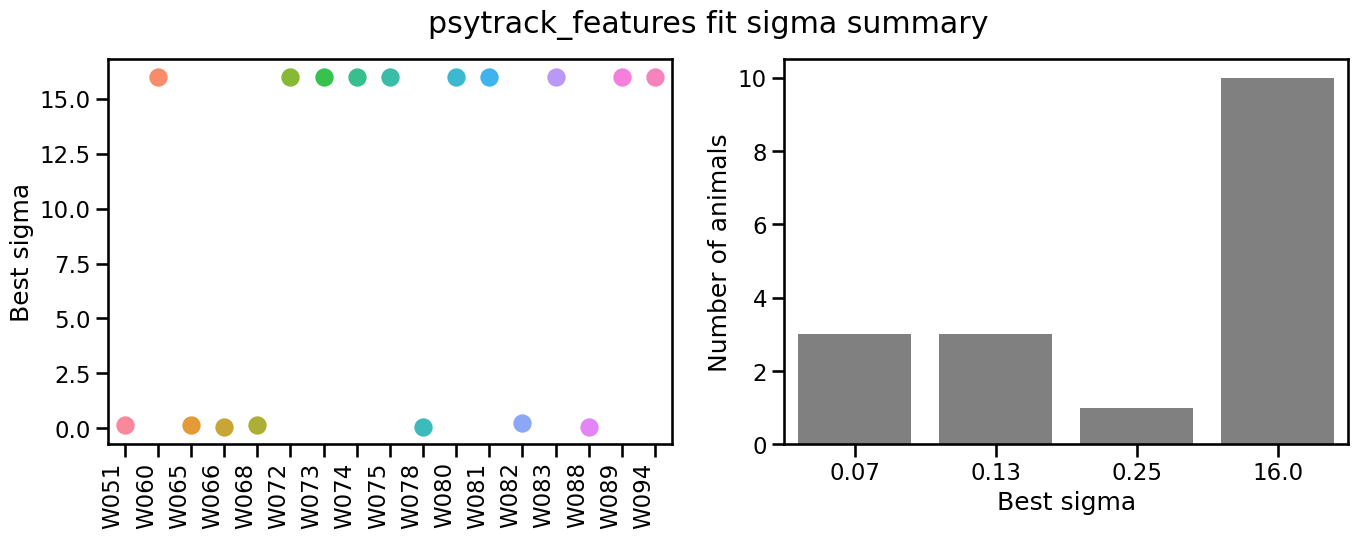

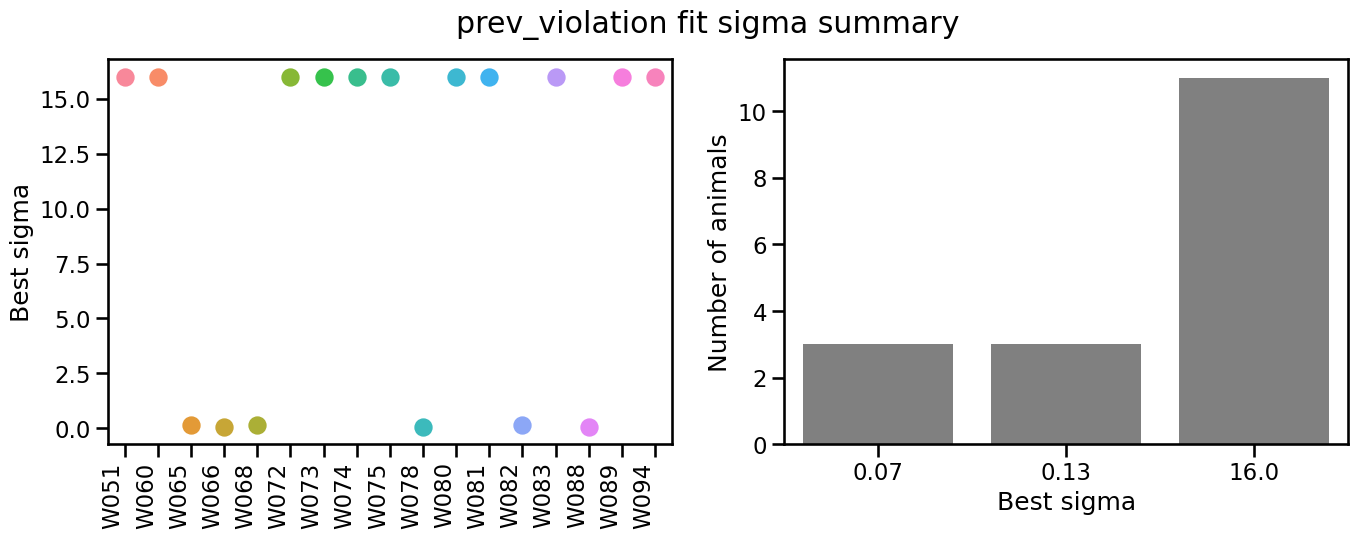

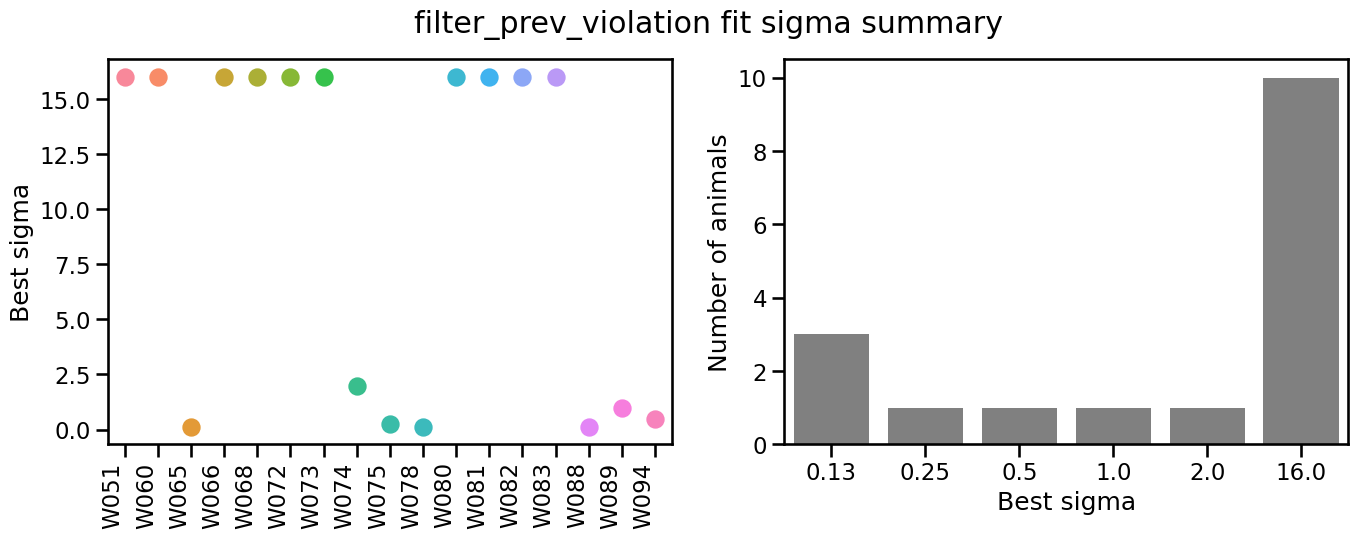

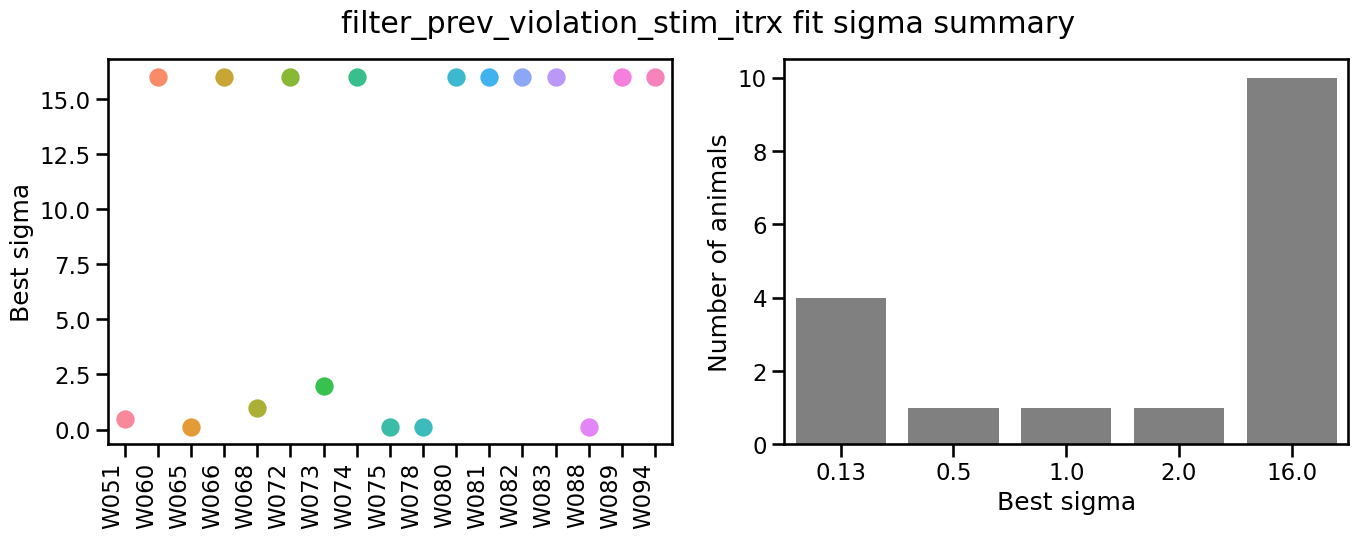

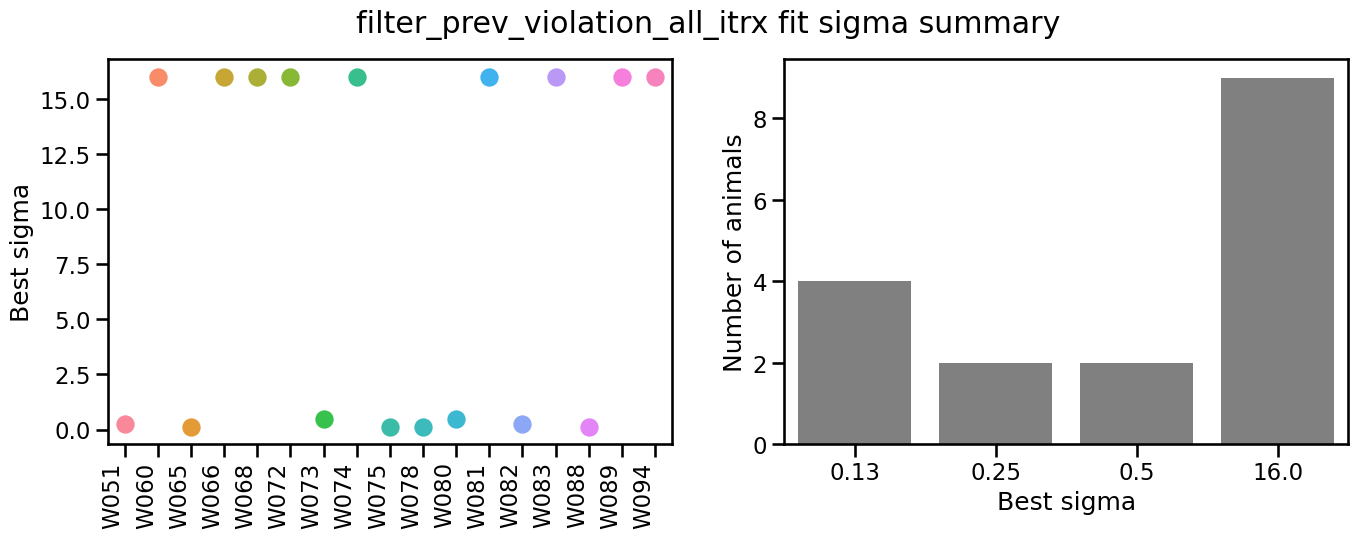

In [12]:
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

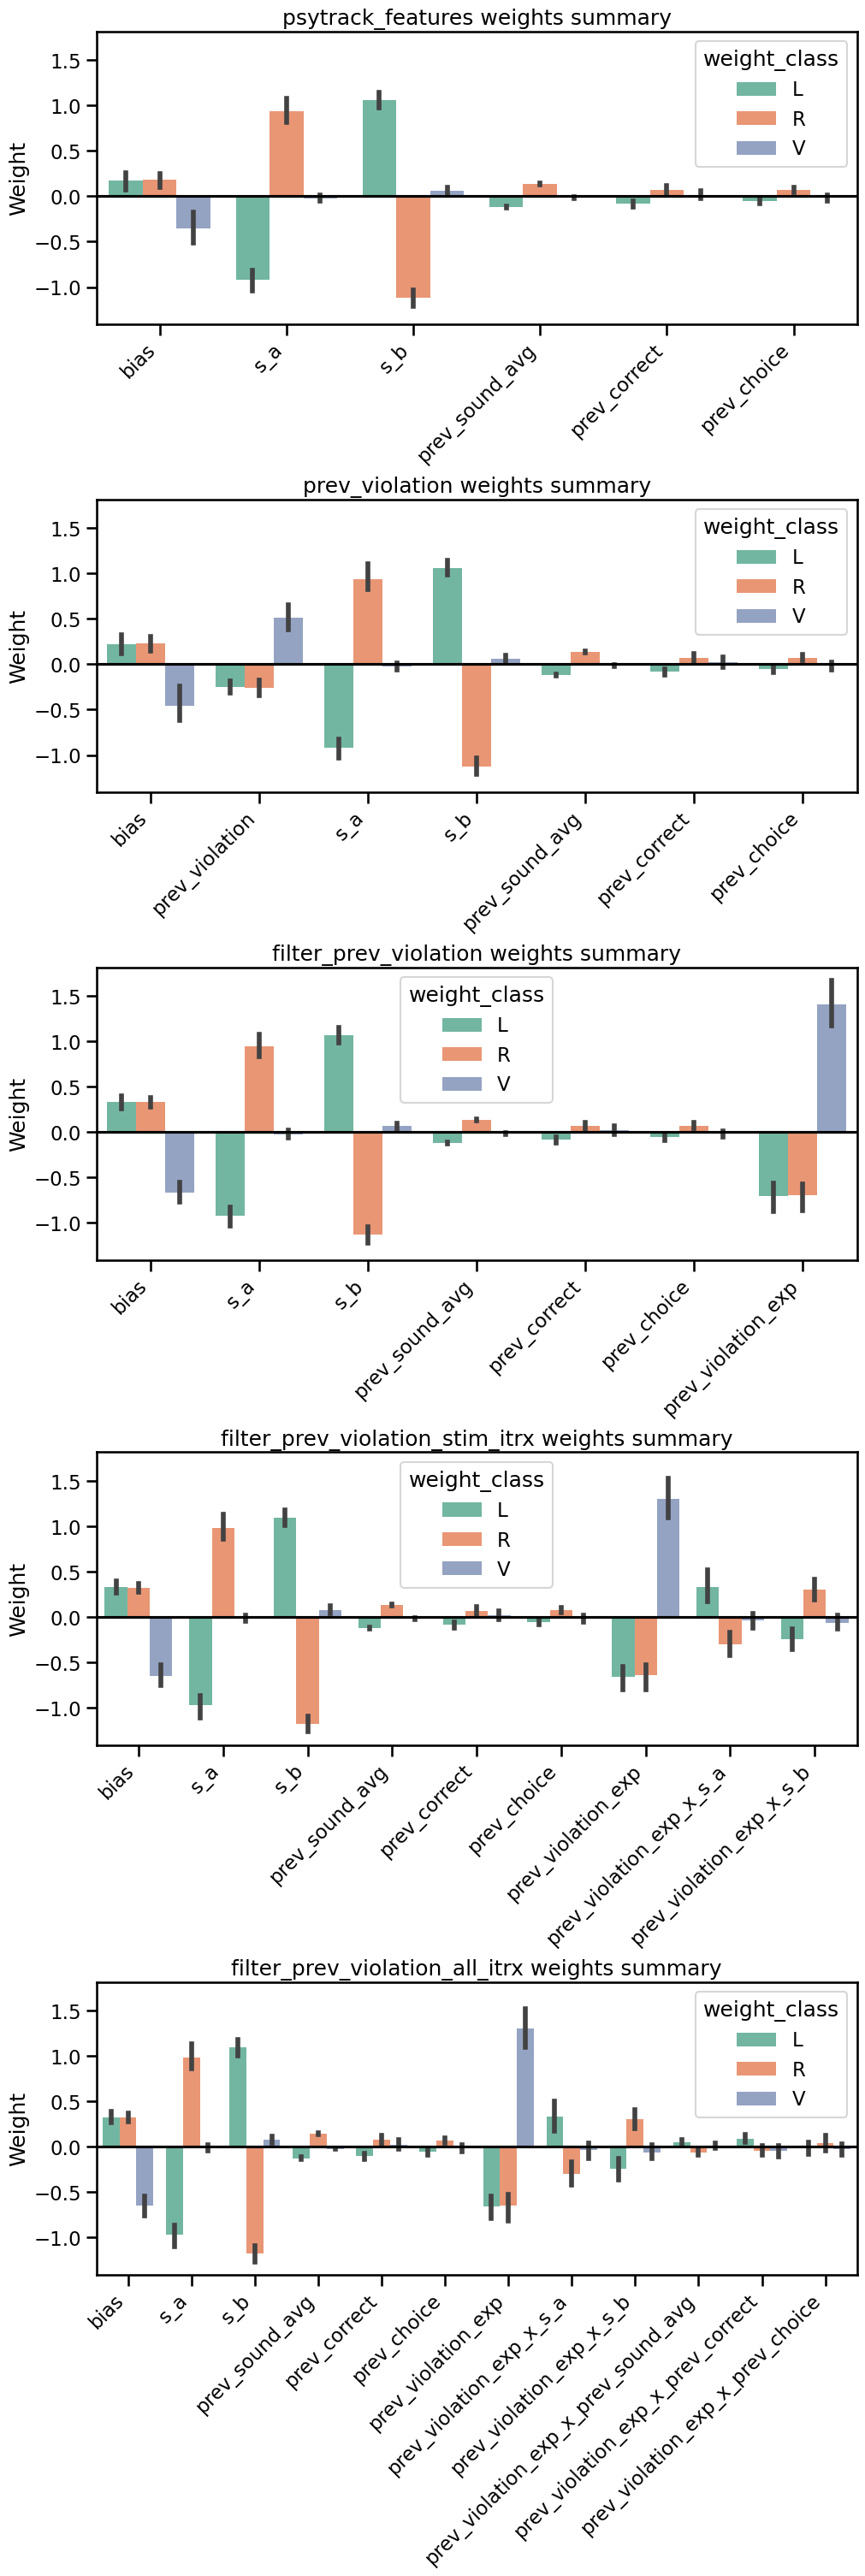

In [6]:
fig, ax = plt.subplots(
    len(ORDER), 1, figsize=(10, len(ORDER) * 6), constrained_layout=True, sharey=True
)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])
best_fit_by_model["model_name"] = pd.Categorical(
    best_fit_by_model["model_name"], categories=ORDER, ordered=True
)

for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
        title=f"{model_name} weights summary",
    )

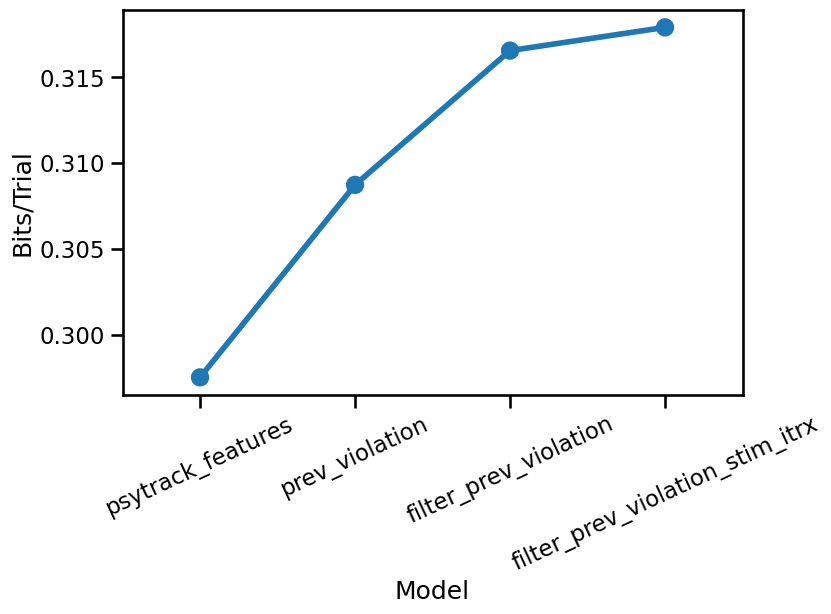

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER[0:-1],
    errorbar=None,
)

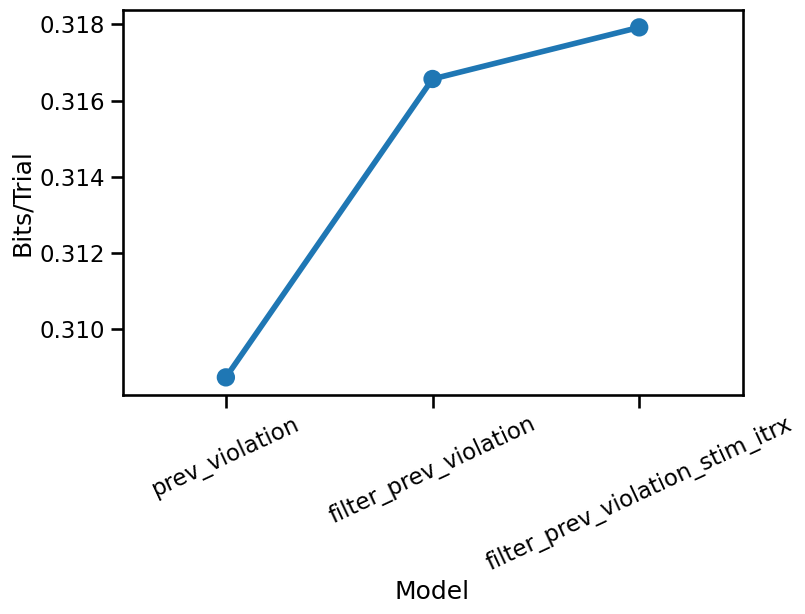

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER[1:-1],
    errorbar=None,
)

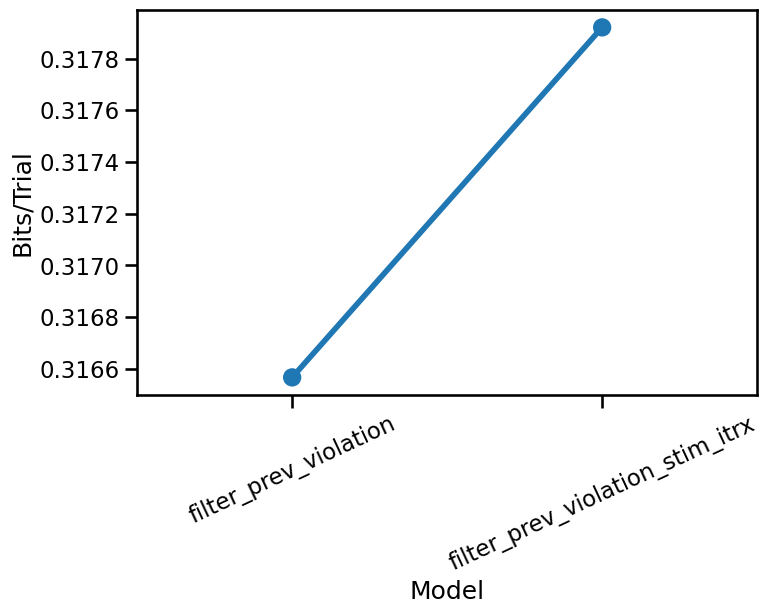

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER[2:4],
    errorbar=None,
)

In [24]:
mvc.compute_bits_per_trial_df().query("model_name !='null'").groupby(
    "model_name"
).bits_per_trial.mean()

model_name
filter_prev_violation              0.316567
filter_prev_violation_all_itrx     0.318079
filter_prev_violation_stim_itrx    0.317921
prev_violation                     0.308737
psytrack_features                  0.297511
Name: bits_per_trial, dtype: float64

In [26]:
0.317921 - 0.316567

0.0013540000000000219

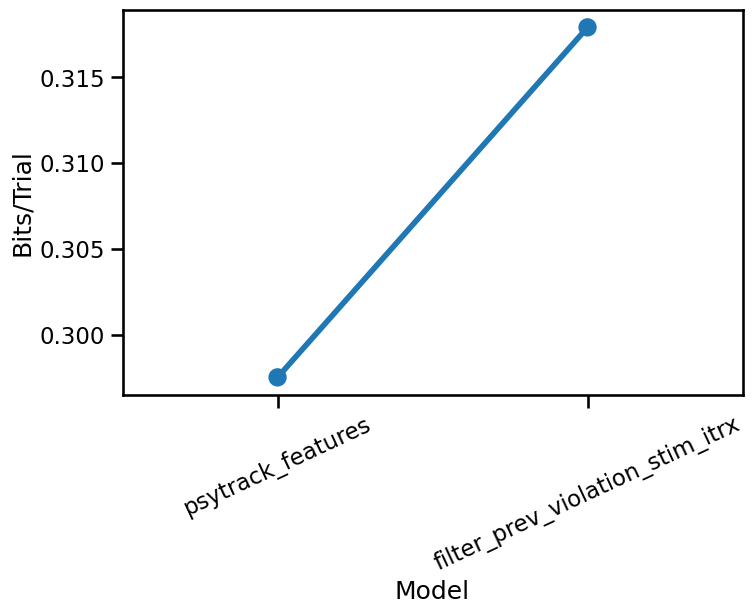

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=[ORDER[0], ORDER[3]],
    errorbar=None,
)

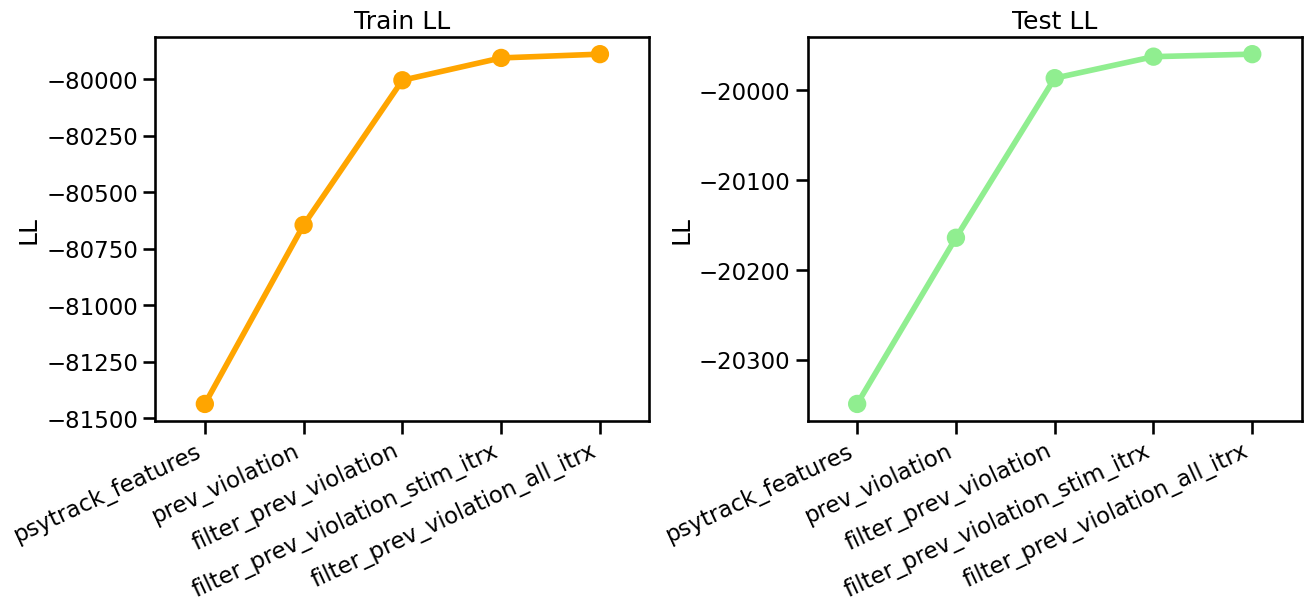

In [9]:
mvc.plot_train_and_test_ll(
    order=ORDER,
    errorbar=None,
)

<Axes: title={'center': 'Model Improvement- mu: 23.94 std: 30.06 \n filter_prev_violation -> filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

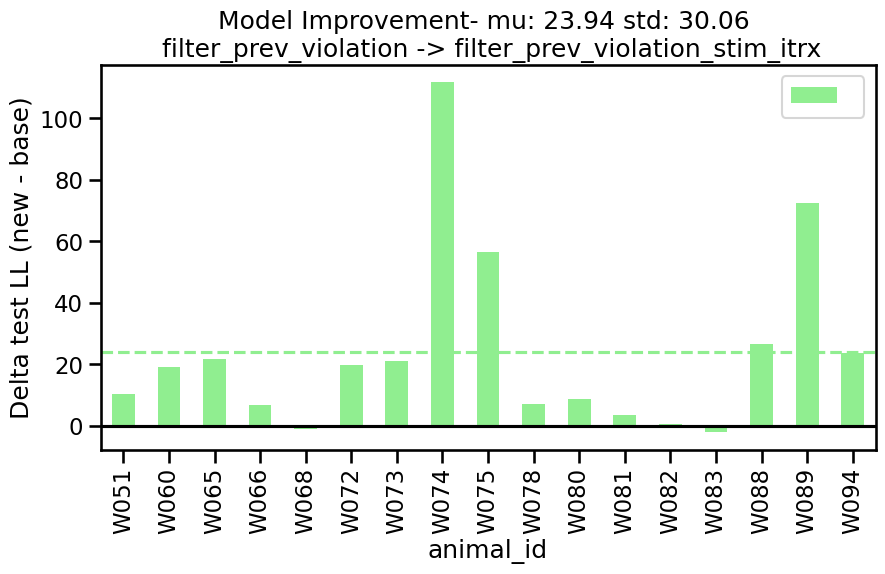

In [27]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[2],
    new_model_name=ORDER[3],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 386.68 std: 338.52 \n psytrack_features -> filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

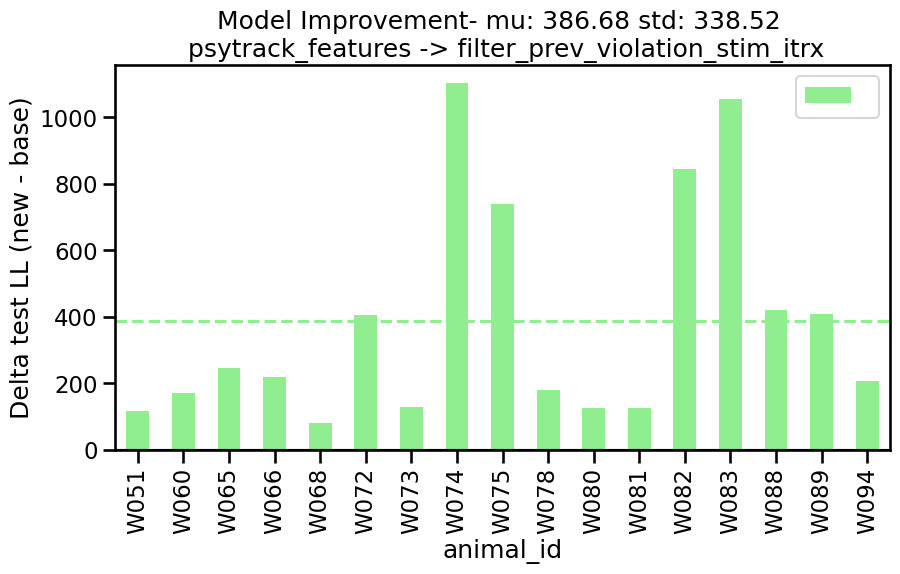

In [9]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[3],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 23.94 std: 30.06 \n filter_prev_violation -> filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

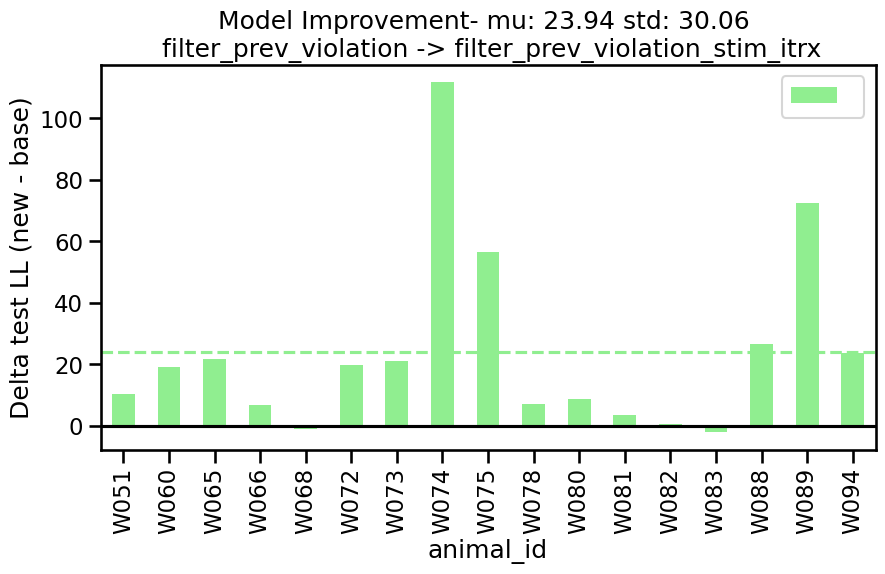

In [10]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[2],
    new_model_name=ORDER[3],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 2.79 std: 2.6 \n filter_prev_violation_stim_itrx -> filter_prev_violation_all_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

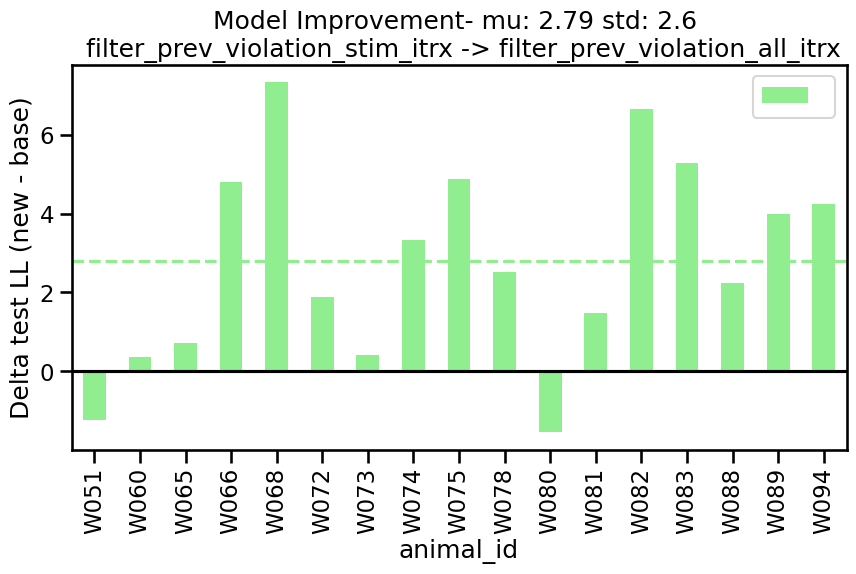

In [12]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[3],
    new_model_name=ORDER[4],
    type="test",
)

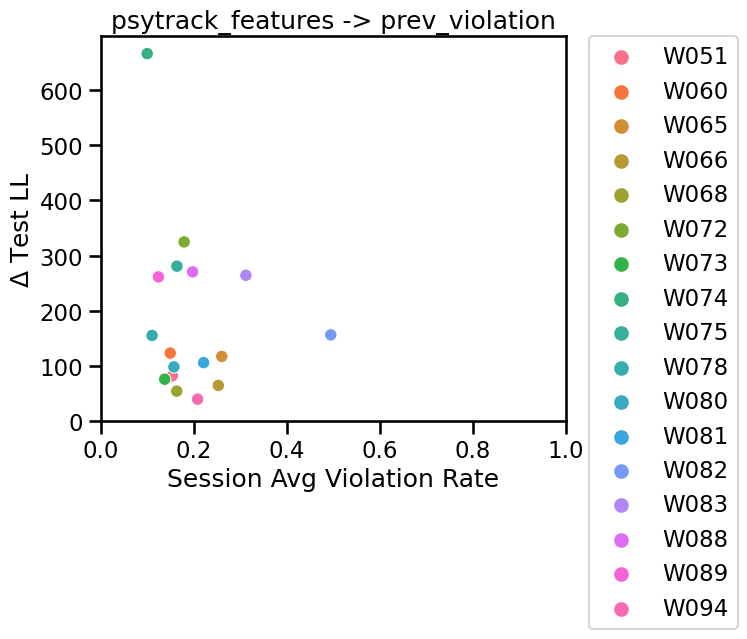

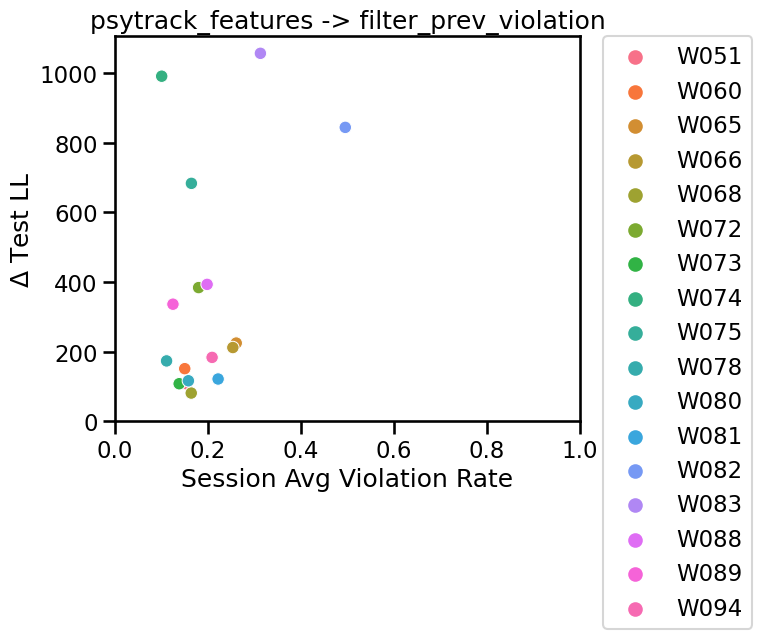

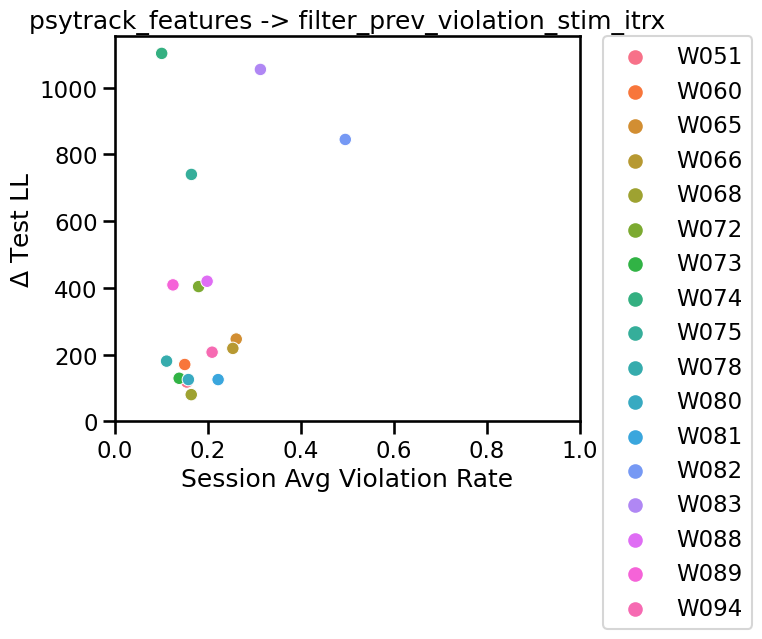

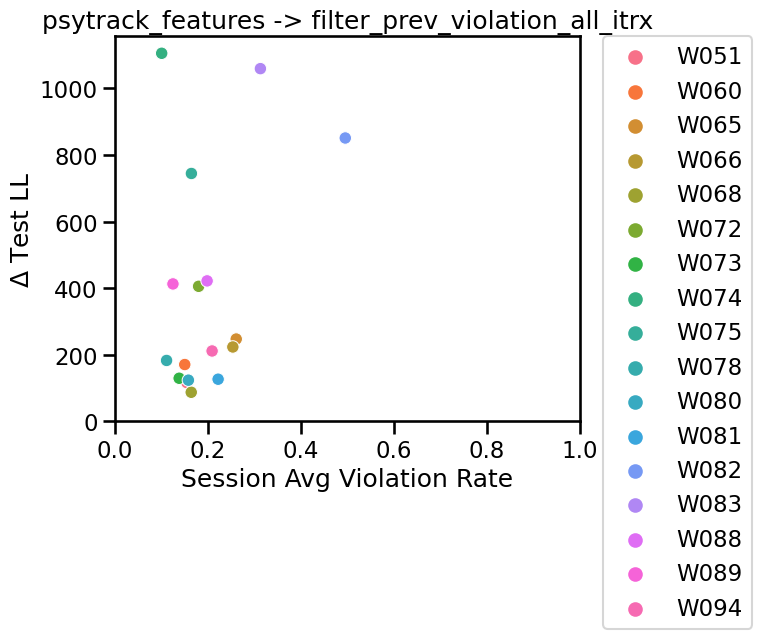

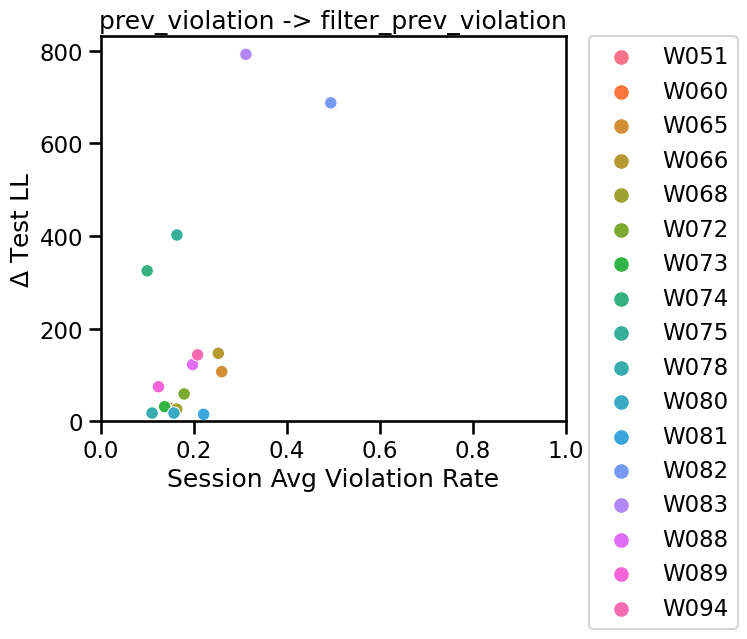

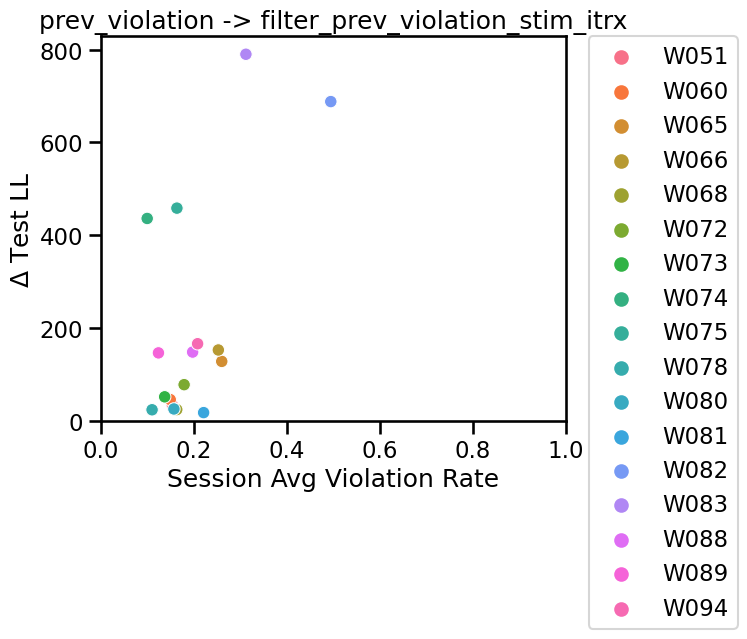

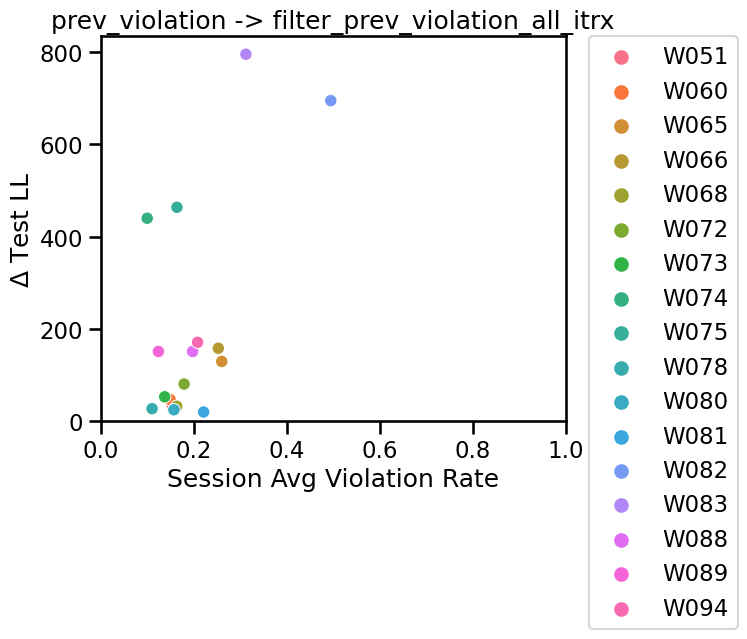

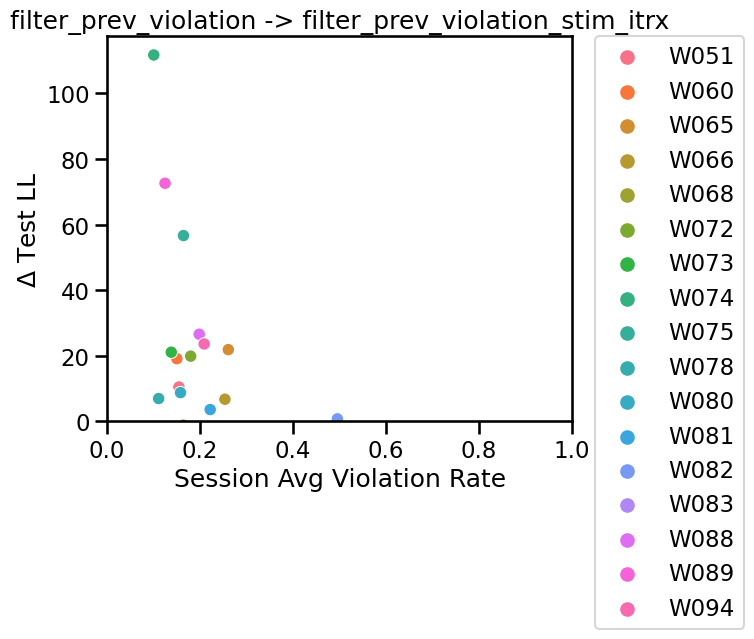

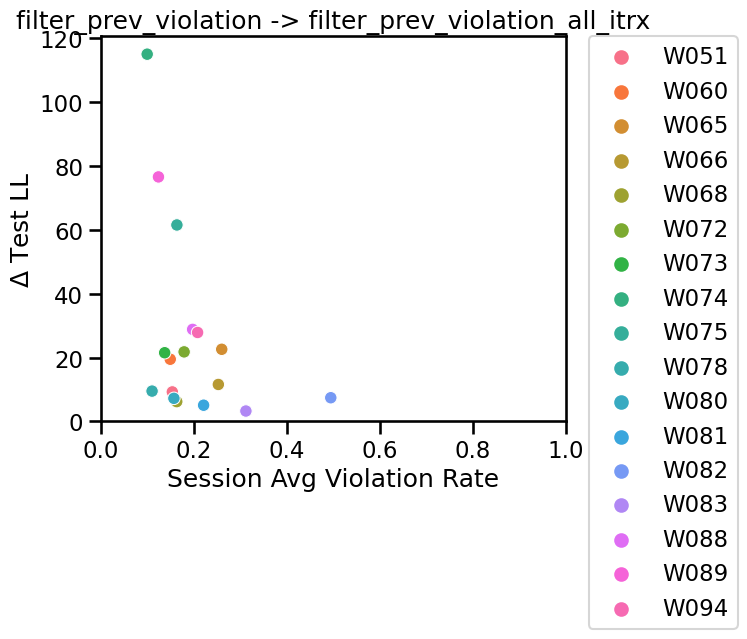

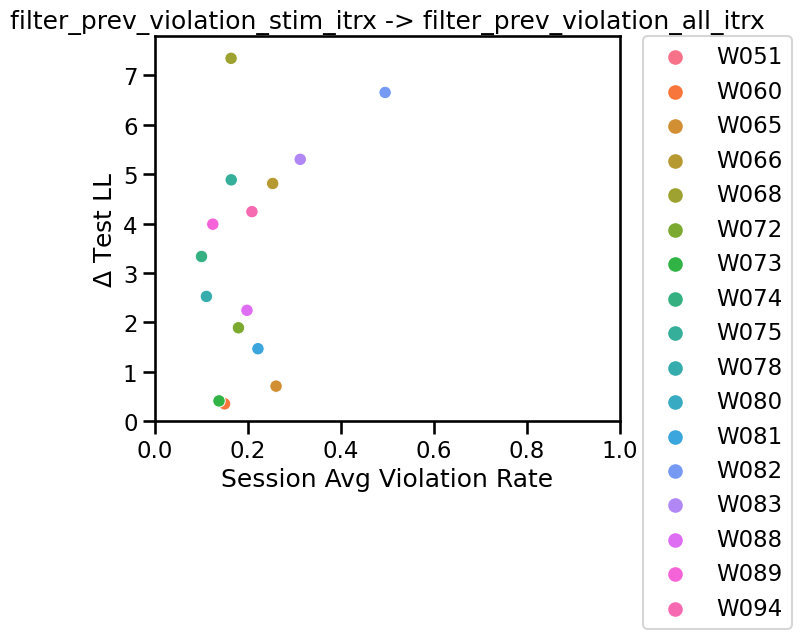

In [13]:
for i in range(len(ORDER)):
    for j in range(i + 1, len(ORDER)):
        mvc.plot_delta_ll_by_violation_rate(ORDER[i], ORDER[j])

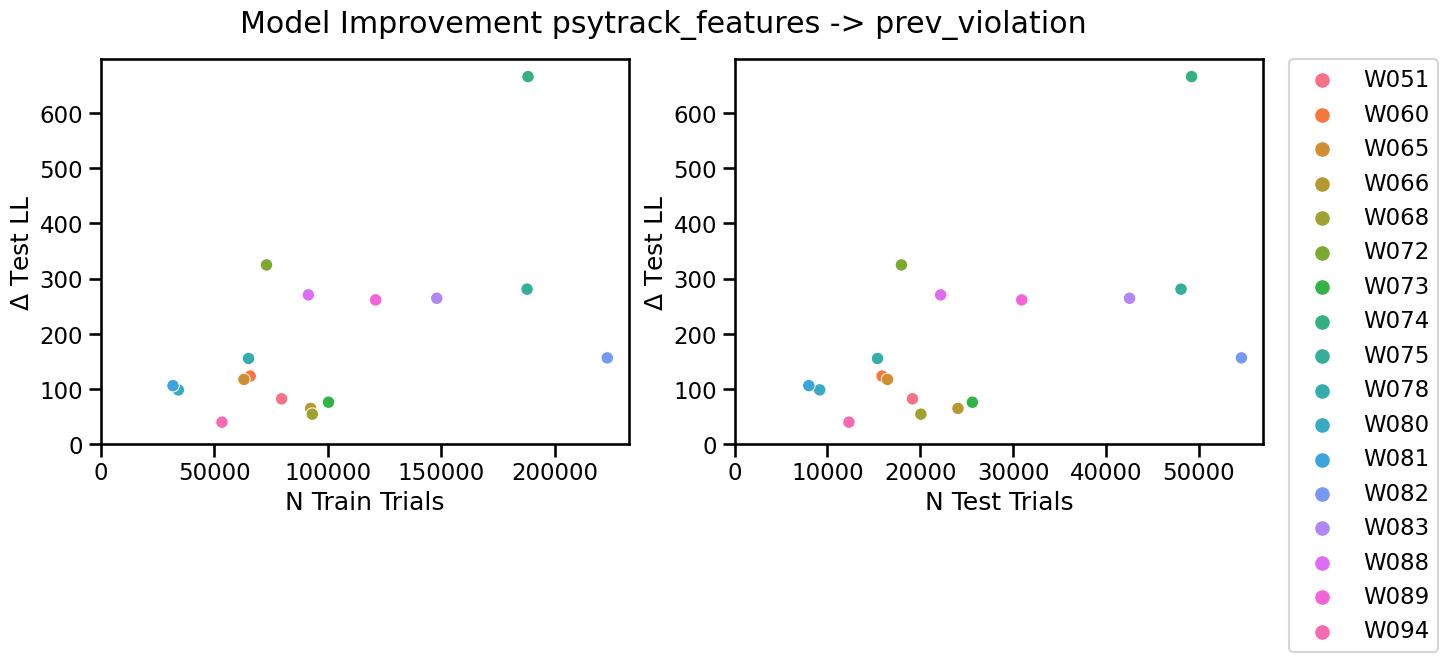

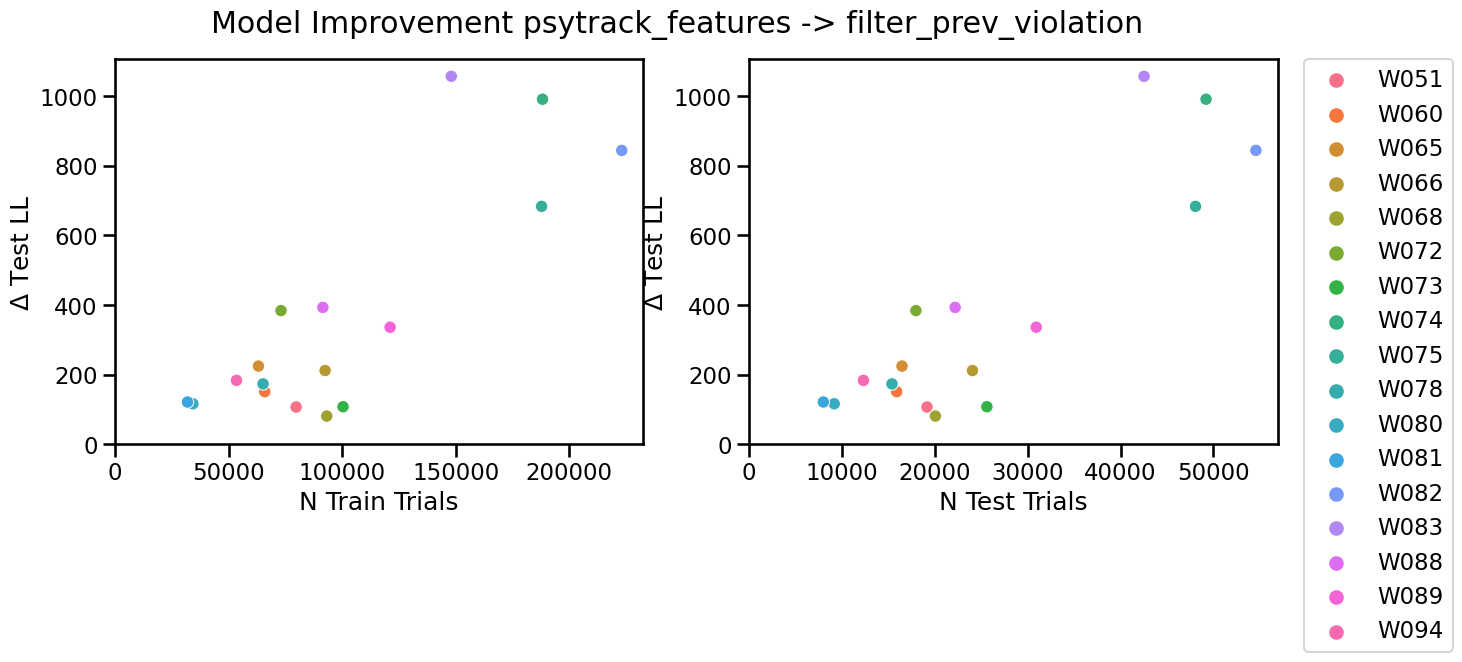

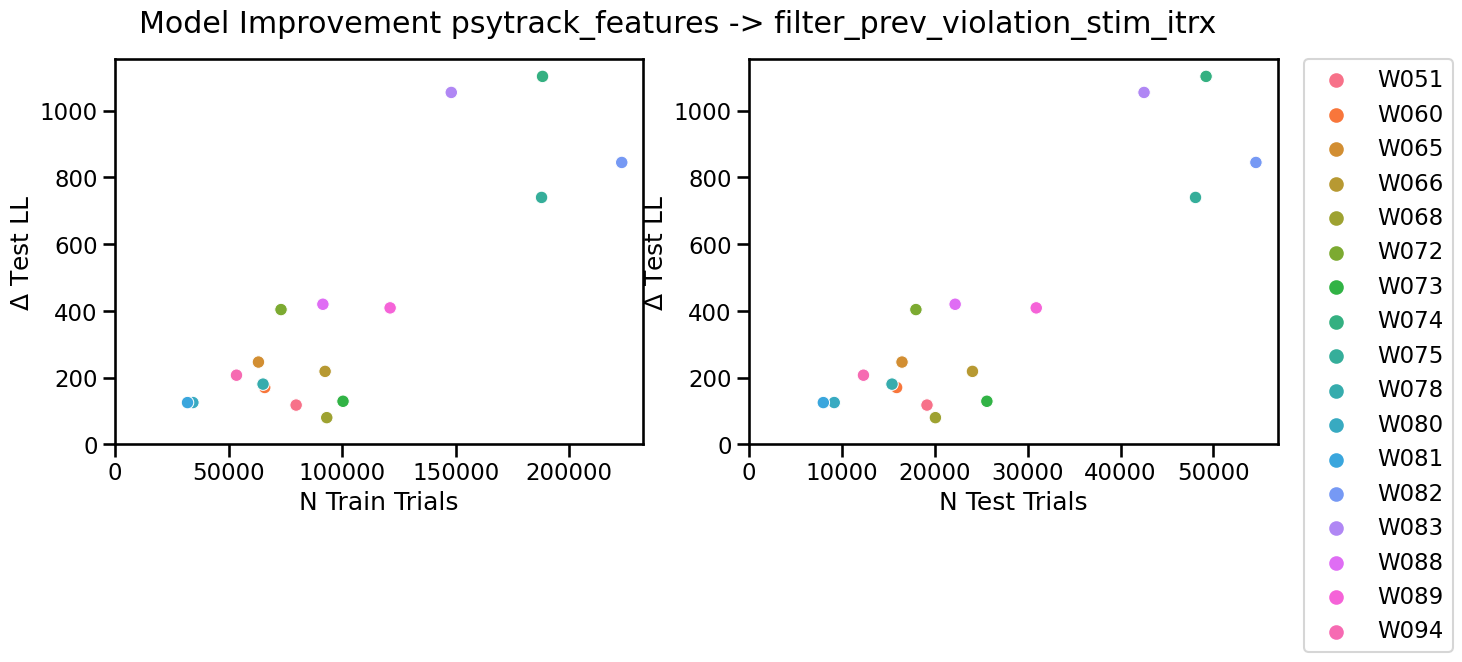

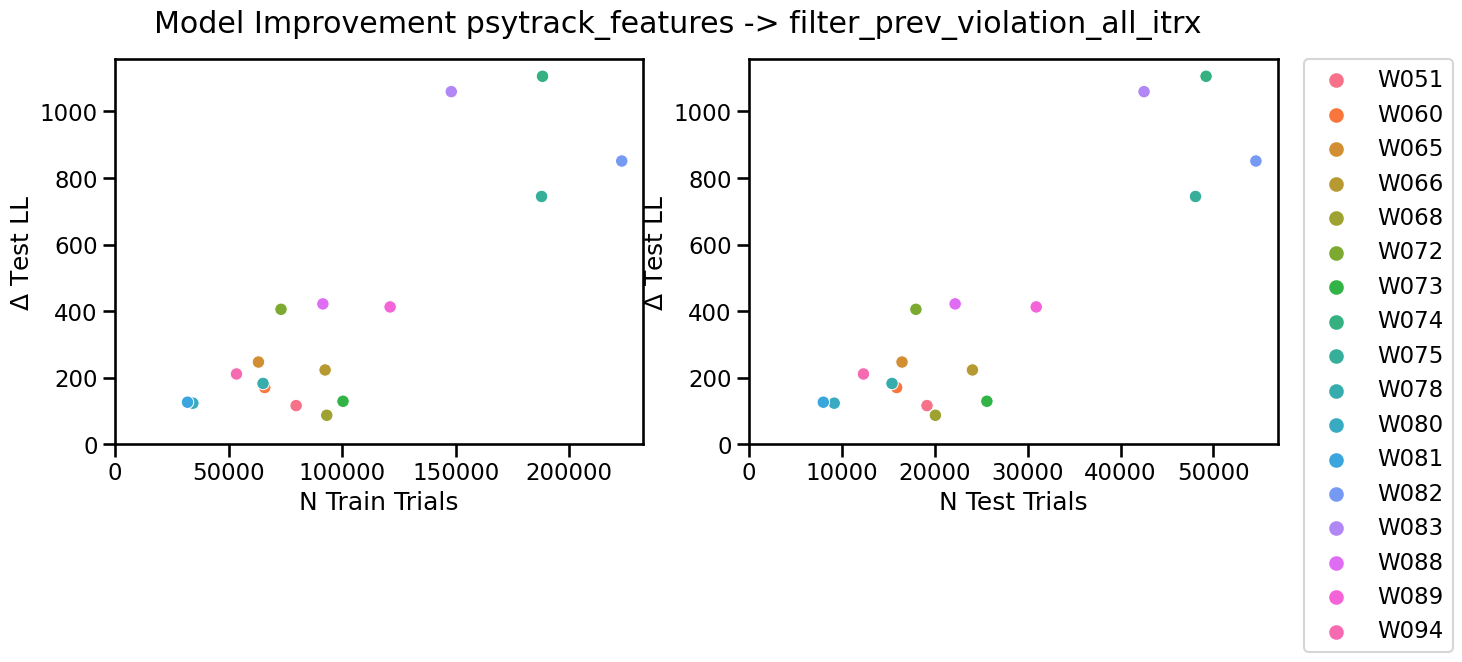

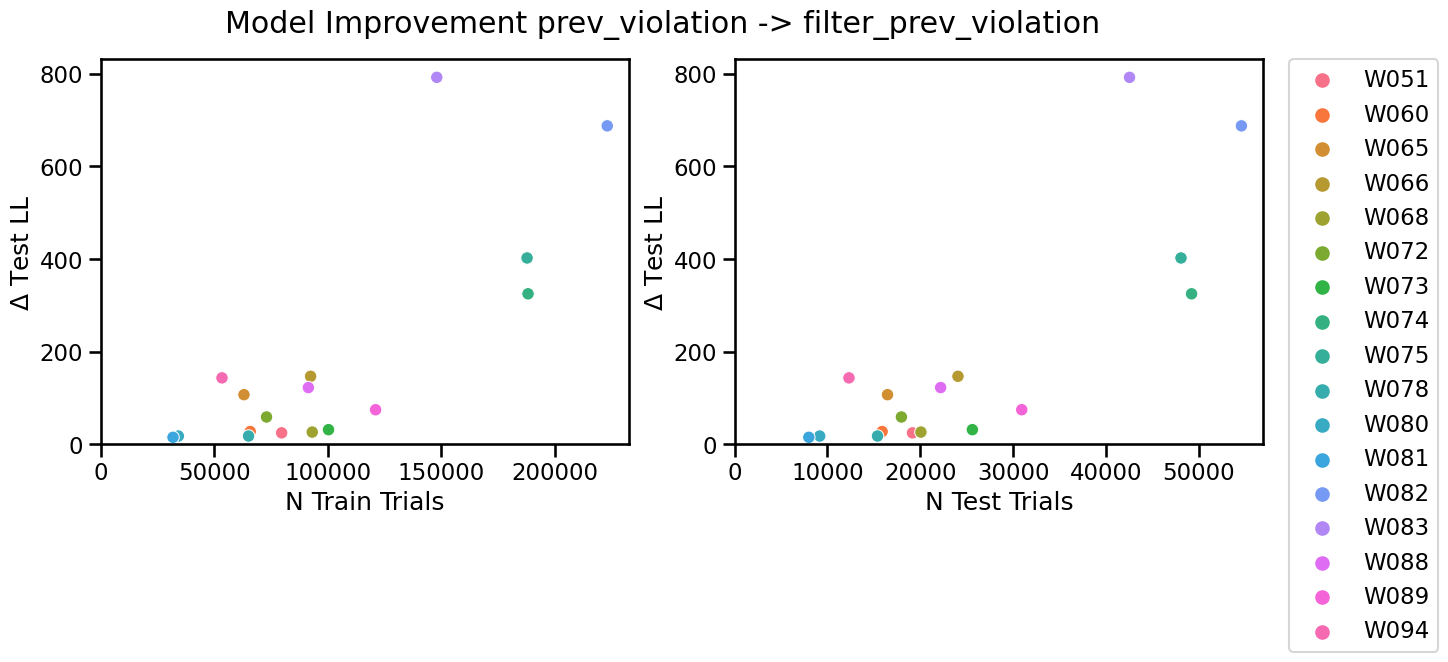

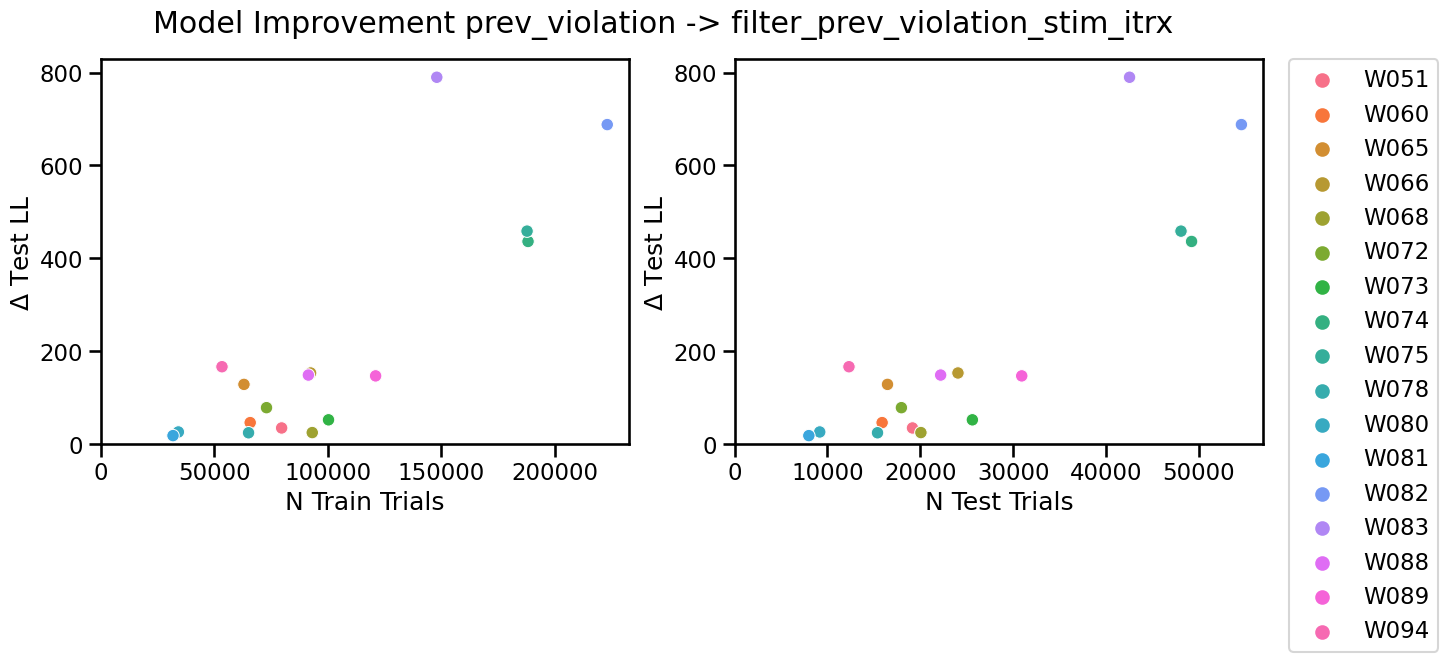

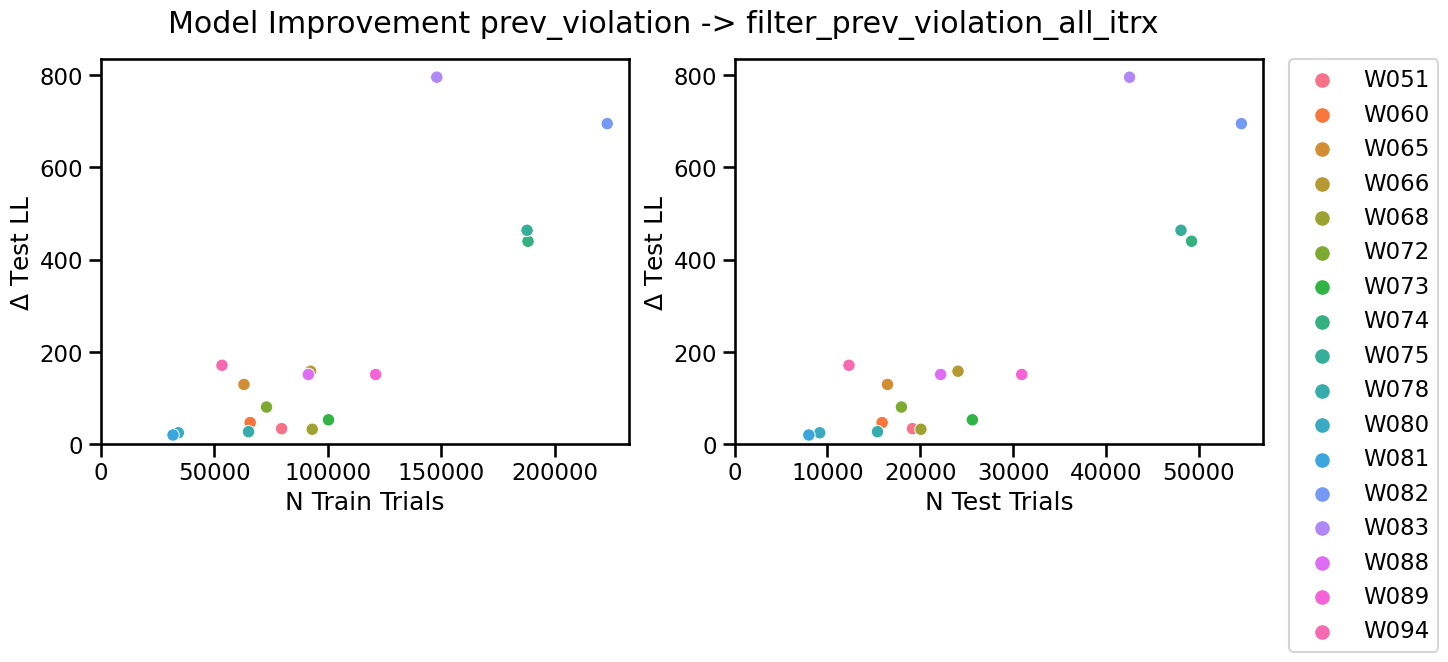

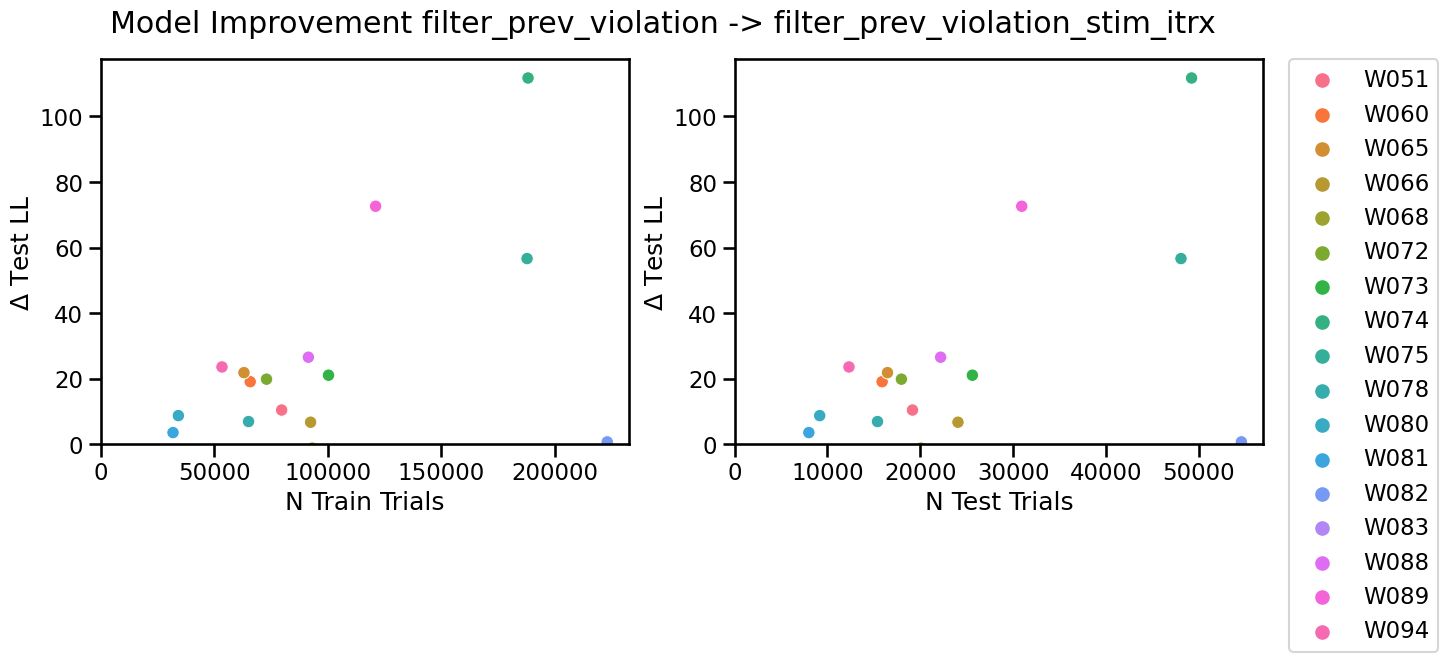

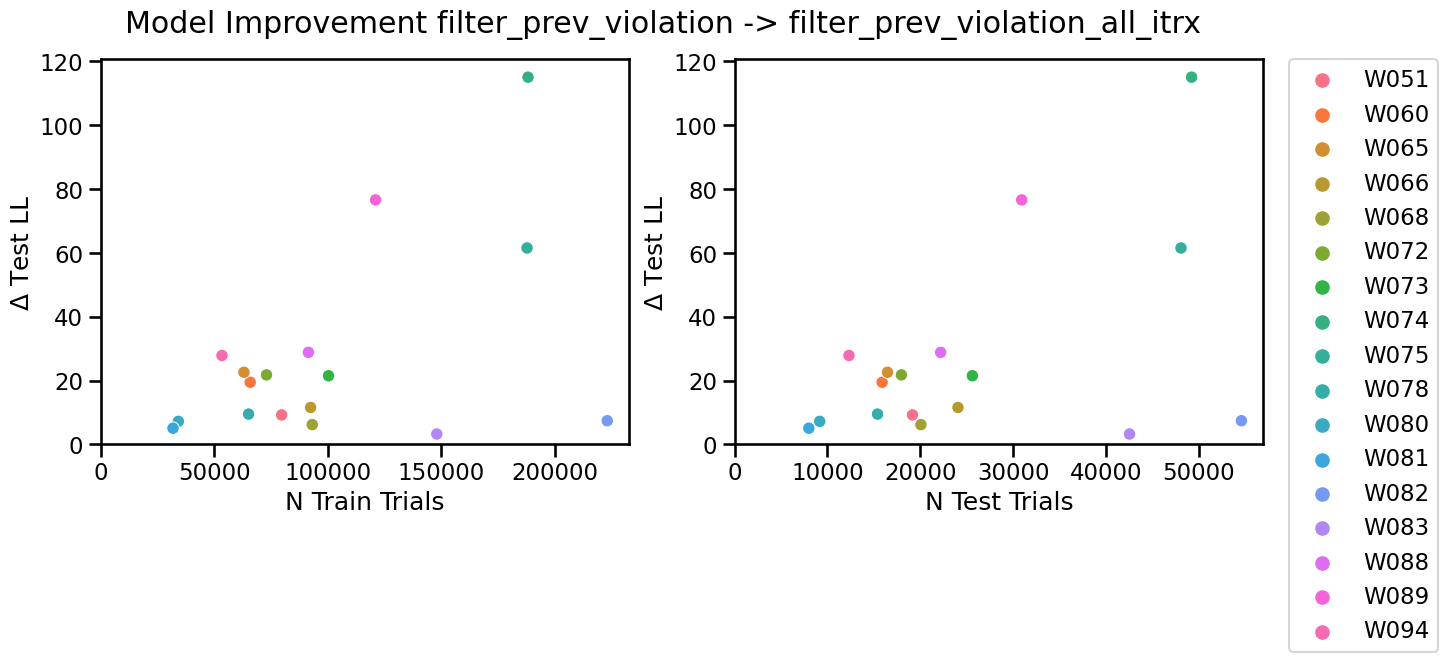

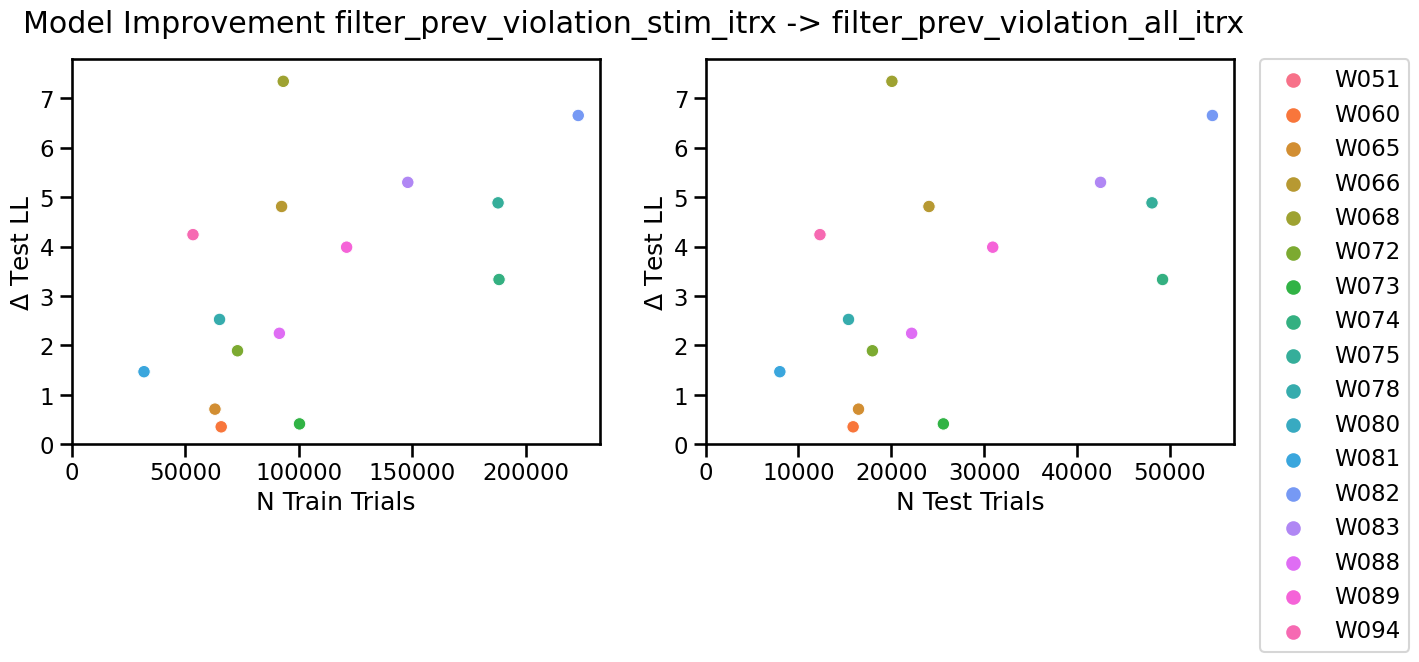

In [14]:
for i in range(len(ORDER)):
    for j in range(i + 1, len(ORDER)):
        mvc.plot_delta_ll_by_train_test_size(ORDER[i], ORDER[j])

In [15]:
# TODO- bits per trial vs violation rate?

In [16]:
# TODO- bits per trial vs violation rate?